In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
house_df = pd.read_csv('./data/Ames_Housing_Price_Data.csv',index_col = 0)
real_estate_df = pd.read_csv('./data/Ames_Real_Estate_Data.csv', index_col = 0, low_memory= False).reset_index()

In [193]:
import pickle

file = open('./pickles/house_latlong.p','rb')

df = pickle.load(file)
real_estate = pickle.load(open('./pickles/real_estate_latlong.p','rb'))

In [198]:
df['Price_per_SF'] = df['SalePrice']/df['GrLivArea']

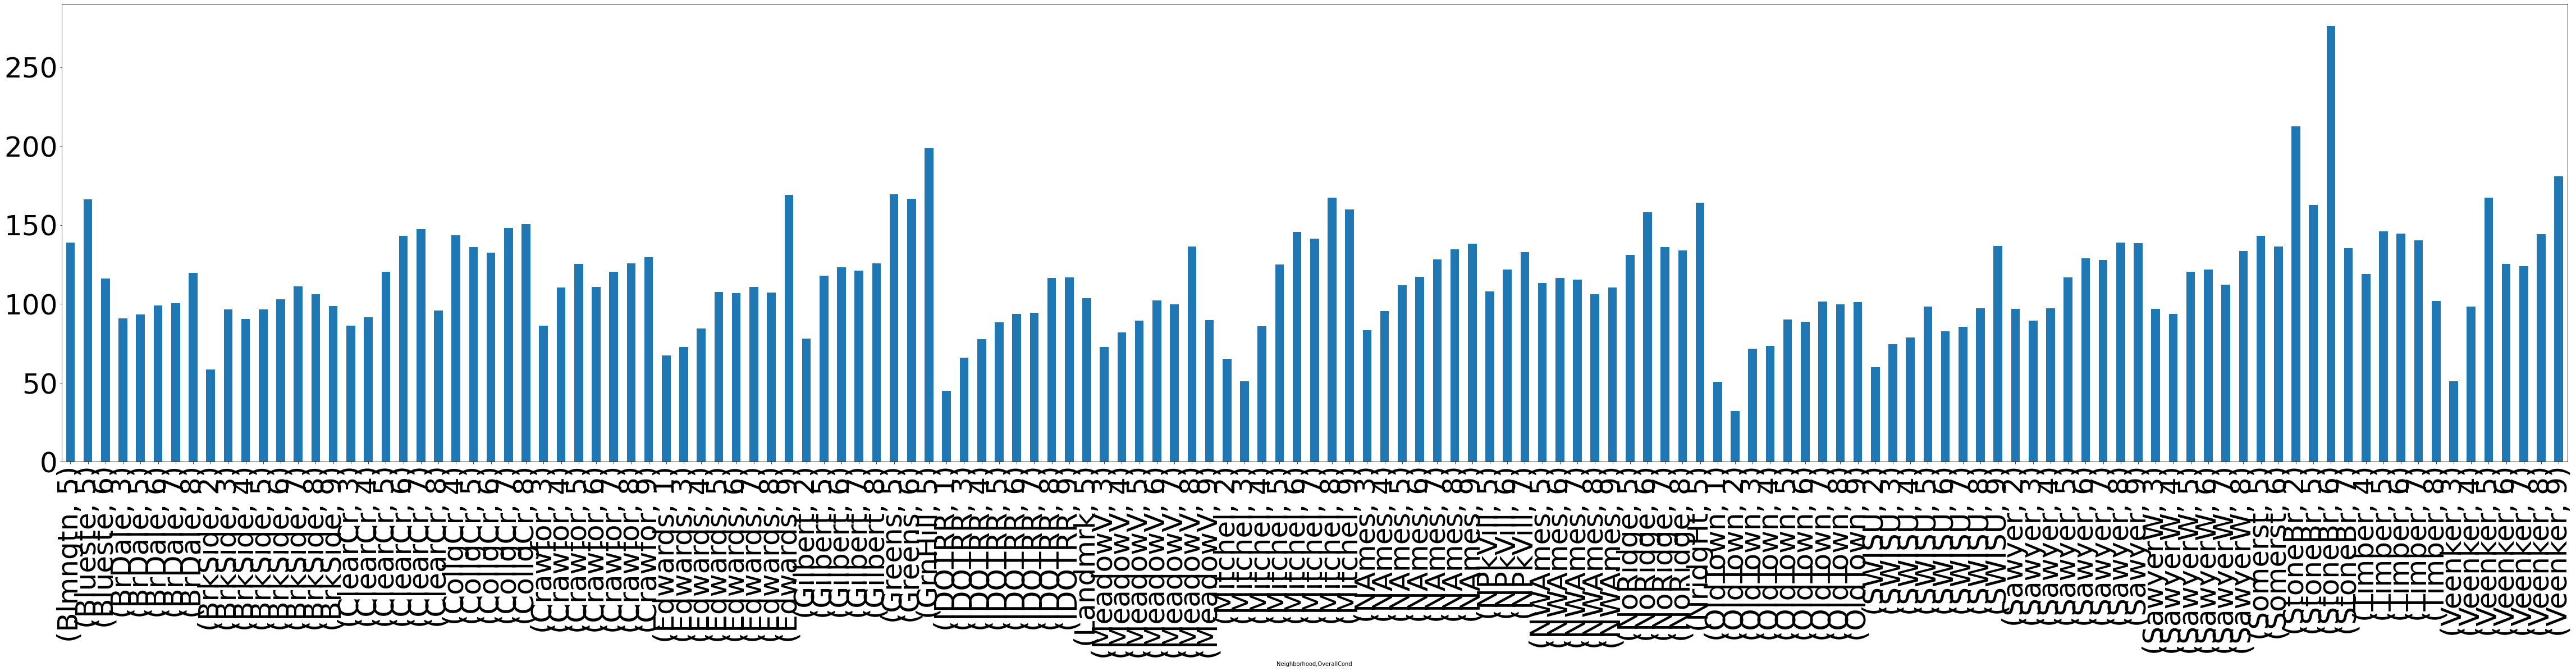

In [39]:
df.groupby(['Neighborhood','OverallCond'],axis = 0)['Price_per_SF'].mean().plot.bar(rot = 90, figsize = (80,15),fontsize = 50)


### PCA to aggregate features

Starting with basement

In [82]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [93]:
pca1 = PCA(n_components=1)
pca2 = PCA(n_components=2)
pca = PCA()

In [84]:
basement = pd.get_dummies(df[[col for col in list(df.columns) if 'Bsmt' in col]].drop('TotalBsmtSF', axis =1))

In [85]:
basement[np.isnan(basement)] = 0

In [88]:
scaler = StandardScaler()
basement = scaler.fit_transform(basement)

In [94]:
pca1.fit_transform(basement)
pca2.fit_transform(basement)
pca.fit_transform(basement)

array([[-8.16662589e-01,  7.99186577e-01, -1.82330837e+00, ...,
         1.71569712e-03,  2.33120165e-13, -1.63233543e-15],
       [ 3.69456093e+00,  1.53756140e+00,  2.64909609e+00, ...,
         5.68955561e-04, -1.89931570e-14,  2.36471516e-14],
       [ 3.69456093e+00,  1.53756140e+00,  2.64909609e+00, ...,
         5.68955561e-04,  1.47191681e-14, -2.18957972e-14],
       ...,
       [-1.44949371e+00,  8.34030325e-01, -1.56969918e+00, ...,
        -2.26716818e-04, -2.25237100e-16, -2.31165999e-16],
       [ 1.48053090e+00, -1.45666318e+00, -5.48574079e-01, ...,
        -1.55860134e-03, -1.23189423e-16, -4.74507983e-18],
       [ 1.70930557e-01, -1.41287794e+00,  8.07854292e-02, ...,
         5.58289789e-04,  1.85442383e-16, -1.59631787e-16]])

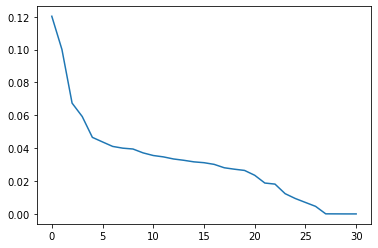

In [98]:
plt.plot(pca.explained_variance_ratio_)

In [104]:
pca.set_params(n_components = 5)
basement_cols = pca.fit_transform(basement)

In [69]:
df_v2 = df.drop([col for col in list(df.columns) if 'Bsmt' in col],axis = 1)

In [107]:
df_v2['basement1'] = basement_cols[:,0]
df_v2['basement2'] = basement_cols[:,1]
df_v2['basement3'] = basement_cols[:,2]
df_v2['basement4'] = basement_cols[:,3]
df_v2['basement5'] = basement_cols[:,4]

18     NaN
23     NaN
49     NaN
53     NaN
55     NaN
        ..
2524   NaN
2531   NaN
2557   NaN
2584   NaN
2590   NaN
Name: GarageYrBlt, Length: 131, dtype: float64

#### Garage

In [130]:
garage = pd.get_dummies(df[[col for col in list(df.columns) if 'Garage' in col]])
garage.loc[np.isnan(garage['GarageYrBlt']),'GarageYrBlt'] = np.mean(garage.loc[~np.isnan(garage['GarageYrBlt']),'GarageYrBlt'])

In [133]:
garage[np.isnan(garage)] = 0

In [134]:
garage = scaler.fit_transform(garage)

In [142]:
pca.set_params(n_components = None)
pca.fit(garage)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

0.7722634339550276


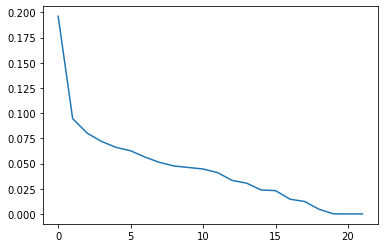

In [144]:
print(sum(pca.explained_variance_ratio_[:10]))

plt.plot(pca.explained_variance_ratio_)

In [148]:
pca.set_params(n_components = 10)
garage_cols = pca.fit_transform(garage)

In [150]:
from sklearn.linear_model import LinearRegression

In [151]:
house_base = df.loc[:,['GrLivArea','SalePrice','LotArea','Street','Neighborhood','Condition1',
                      'HouseStyle','OverallQual','OverallCond','RoofStyle','YearBuilt','YearRemodAdd',
                      'Exterior1st','Foundation','Fireplaces','GarageArea','PoolArea',
                      'MoSold','YrSold','SaleCondition','SaleType']]

house_base = pd.get_dummies(house_base) #one hot encode
house_base = house_base.drop(['SaleType_WD ','SaleCondition_Abnorml','Foundation_Wood',
                             'Exterior1st_WdShing','Neighborhood_Landmrk','Street_Grvl',
                             'RoofStyle_Shed','HouseStyle_2.5Fin'], axis = 1)

In [158]:
X = np.concatenate((house_base.drop('SalePrice',axis =1).values,basement_cols,garage_cols), axis = 1)

In [176]:
X[np.isnan(X)] = 0

In [177]:
Y = house_base['SalePrice']

In [178]:
lm = LinearRegression()

In [179]:
lm.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [180]:
lm.score(X,Y)

0.893053561037348

### The whole damn thing

In [327]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV

In [254]:
df_dumb.info(verbose = 1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2537 entries, 0 to 2623
Data columns (total 281 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   GrLivArea              int64  
 1   SalePrice              int64  
 2   LotFrontage            float64
 3   LotArea                int64  
 4   OverallQual            int64  
 5   OverallCond            int64  
 6   YearBuilt              int64  
 7   YearRemodAdd           int64  
 8   MasVnrArea             float64
 9   BsmtFinSF1             float64
 10  BsmtFinSF2             float64
 11  BsmtUnfSF              float64
 12  TotalBsmtSF            float64
 13  1stFlrSF               int64  
 14  2ndFlrSF               int64  
 15  LowQualFinSF           int64  
 16  BsmtFullBath           float64
 17  BsmtHalfBath           float64
 18  FullBath               int64  
 19  HalfBath               int64  
 20  BedroomAbvGr           int64  
 21  KitchenAbvGr           int64  
 22  TotRmsAbvGrd           

In [294]:
df_dumb = pd.get_dummies(df.drop(['PID','MSSubClass','MSZoning','MapRefNo',
                                  'Prop_Addr','Alley','FireplaceQu',
                                  'PoolQC'],axis =1))
df_dumb.loc[np.isnan(df_dumb['GarageYrBlt']),'GarageYrBlt'] = np.mean(df_dumb.loc[~np.isnan(df_dumb['GarageYrBlt']),'GarageYrBlt'])
df_dumb = df_dumb[~np.isnan(df_dumb.latitude)]
df_dumb.loc[np.isnan(df_dumb['LotFrontage']),'LotFrontage'] = 0
df_dumb.loc[np.isnan(df_dumb['MasVnrArea']),'MasVnrArea'] = 0
df_dumb[np.isnan(df_dumb)] = 0

Y = df_dumb['SalePrice']
X = df_dumb.drop(['SalePrice','Price_per_SF'],axis =1)

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = .2)

In [329]:
lmr = Ridge()
lml = Lasso()
params = {'alpha': [.01,.1,1,2,3,4,5,10,100]}
gcv2 = GridSearchCV(lmr,param_grid=params)

gcv2.fit(x_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.01, 0.1, 1, 2, 3, 4, 5, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [331]:
r_squared = gcv2.score(x_test,y_test)

In [332]:
adjusted_r_squared = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-X.shape[1]-1)

In [333]:
print(r_squared,adjusted_r_squared)

0.9390548239720323 0.9315210605197493


In [319]:
pca = PCA(n_components = 100)
lm = LinearRegression()
#params = {'alpha': [.01,.1,1,2,3,4,5,10,100]}
#gcv = GridSearchCV(lm,param_grid=params)
pca_lm = make_pipeline(pca,lm)
pca_lm.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=100,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [320]:
pca_lm.score(x_test,y_test)

0.9290176617216899

In [321]:
r_squared = pca_lm.score(x_test,y_test); adjusted_r_squared = 1 - (1-r_squared)*(len(Y)-1)/(len(Y)-100-1)

In [322]:
print(r_squared,adjusted_r_squared)

0.9290176617216899 0.9261037726298053
